In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle

import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords
#from nltk.stem import LancasterStemmer,WordNetLemmatizer
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()


import re,string,unicodedata, copy
import random


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from collections import Counter
from sklearn.metrics import *

import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)

[nltk_data] Downloading package punkt to /home/vscode/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/vscode/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:

train = pd.read_csv('/workspaces/NLP_Final_Twiiter-Offense-Classification/01_Data/02_Processed/train.csv')
test = pd.read_csv('/workspaces/NLP_Final_Twiiter-Offense-Classification/01_Data/02_Processed/test.csv')


# Combining the train and test data for cleaning
combine=pd.concat([train,test],ignore_index=True)

#### changing labels to 1 and 0 for better understanding

In [3]:
combine['class']= combine['class'].replace(2, 0)

In [4]:
combine['class'].value_counts()

class
1    4000
0    4000
Name: count, dtype: int64

#### lemmitize 

In [5]:
def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

# Apply lemmatization to the 'text' column
combine['clean_tweet'] = combine['clean_tweet'].apply(lambda x: lemmatize_text(x))

In [6]:
train_imdb, test_imdb = train_test_split(combine,test_size = 0.2)
x_train,y_train,x_test,y_test = train_imdb['clean_tweet'].values,train_imdb['class'].values,test_imdb['clean_tweet'].values,test_imdb['class'].values
print(f'Train data has {x_train.shape[0]} samples')
print(f'Test data has {x_test.shape[0]} samples')

Train data has 6400 samples
Test data has 1600 samples


In [7]:
#convert training and test to tfidf vectors
vectorizer = TfidfVectorizer()
vectorizer.fit(x_train)
x_train1 = vectorizer.transform(x_train)
x_test1 = vectorizer.transform(x_test)

In [8]:
word_list = []

for sent in x_train:
    for word in sent.split():
        if word != '':
            word_list.append(word)

#make vocab dictionary
corpus = Counter(word_list)
corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:4000]

#transform courpus to tfidf vector
vocabvec = vectorizer.transform(np.array(corpus_))

In [9]:
print(f'Length of vocabulary is {len(corpus_)}')

Length of vocabulary is 4000


### Naive Bayes model fitting on Real World Dataset


In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import normalize
clf = MultinomialNB()
clf.fit(x_train1, y_train)
print(f'Naive Bayes model accuracy: {clf.score(x_test1, y_test)*100}%')

Naive Bayes model accuracy: 89.125%


### Model evaluation against validation set


In [11]:
y_pred = clf.predict(x_test1)
conf_matrix = confusion_matrix(y_test, y_pred)


TN, FP, FN, TP = conf_matrix[0, 0], conf_matrix[0, 1], conf_matrix[1, 0], conf_matrix[1, 1]

# Calculate Specificity and Sensitivity
specificity = TN / (TN + FP)
sensitivity = TP / (TP + FN)

print(f"Specificity (True Negative Rate): {specificity}")
print(f"Sensitivity (True Positive Rate): {sensitivity}")

Specificity (True Negative Rate): 0.8242574257425742
Sensitivity (True Positive Rate): 0.9595959595959596


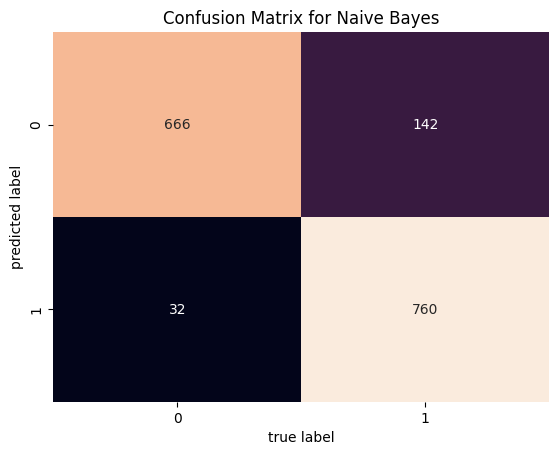

In [12]:
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)

plt.title('Confusion Matrix for Naive Bayes')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

F1 Score with Naive-bayes:  0.8908092306100274
AUC with Naive-bayes:  0.891926692669267


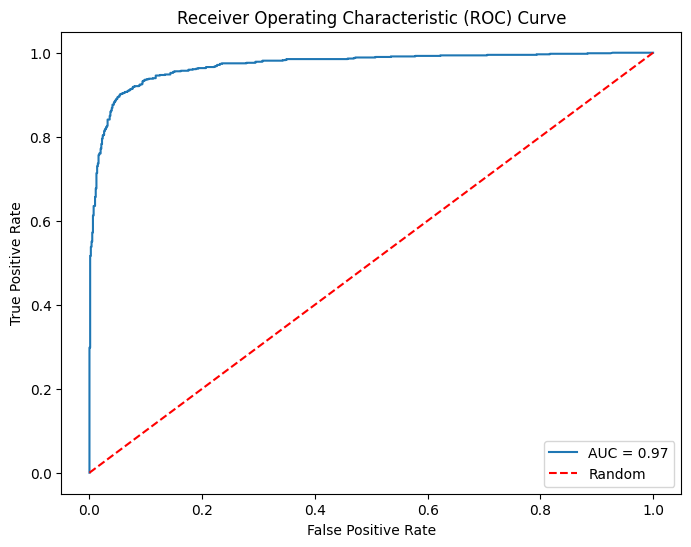

In [13]:
# F1 Score
f1_naive = f1_score(y_test, y_pred, average='weighted')
print("F1 Score with Naive-bayes: ",f1_naive)

# AUC
auc_naive = roc_auc_score(y_test, y_pred)
print("AUC with Naive-bayes: ",auc_naive)

y_prob = clf.predict_proba(x_test1)
fpr, tpr, thresholds = roc_curve(y_test, y_prob[:, 1])  # Considering probabilities for the positive class
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'r--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()


## Synthetic data

In [14]:
combine.head()

,offensive,class,clean_tweet,tokenized
0,Yes,1,know bitch,"['know', 'bitch']"
1,No,0,oreo ice cream httptcothrkaobdvj,"['oreo', 'ice', 'cream', 'httptcothrkaobdvj']"
2,Yes,1,swear got shit make bitch go insane,"['swear', 'got', 'shit', 'make', 'bitch', 'go'..."
3,No,0,want oreo help,"['want', 'oreo', 'help']"
4,No,0,clean dead bird piece glass,"['clean', 'dead', 'bird', 'piec', 'glass']"


In [15]:
#generate probabilities of a word in corpus being neg or pos
proba = clf.predict_proba(vocabvec)

In [16]:
from collections import defaultdict

# Assuming proba is a list of probabilities associated with each word in corpus_
# proba should have the same length as corpus_
# Replace proba with your actual list of probabilities

pos_vocab = defaultdict(float)
neg_vocab = defaultdict(float)

for i, w in enumerate(corpus_):
    # Assuming proba[i] contains the probabilities associated with word w
    pos_vocab[w] = proba[i][1]  # Assuming proba[i][1] contains positive class probability
    neg_vocab[w] = proba[i][0]  # Assuming proba[i][0] contains negative class probability


In [26]:
import numpy as np

# Assuming you have num_reviews and num_words_per_review defined earlier
threshold = 0.5  # Set your threshold here
num_reviews = 4000
num_words_per_review = np.random.randint(5, 10, size=num_reviews).tolist()

# Initialize an empty list to store synthetic positive and negative reviews
pos_reviews = []
neg_reviews = []

# Generate synthetic positive reviews
for i in range(num_reviews):
    pos_probs = np.array(list(pos_vocab.values()))
    pos_probs /= pos_probs.sum()  # Normalize probabilities to ensure they sum up to 1
    pos_review_words = np.random.choice(list(pos_vocab.keys()), size=num_words_per_review[i], replace=True, p=pos_probs)
    pos_review = ' '.join(pos_review_words)
    pos_reviews.append(pos_review)

# Generate synthetic negative reviews
for i in range(num_reviews):
    neg_probs = np.array(list(neg_vocab.values()))
    neg_probs /= neg_probs.sum()  # Normalize probabilities to ensure they sum up to 1
    neg_review_words = np.random.choice(list(neg_vocab.keys()), size=num_words_per_review[i], replace=True, p=neg_probs)
    neg_review = ' '.join(neg_review_words)
    neg_reviews.append(neg_review)

# Combine positive and negative reviews into a single list
rev_list = pos_reviews + neg_reviews

# Create corresponding sentiments (1 for positive, 0 for negative)
sen_list = [1] * num_reviews + [0] * num_reviews

# Create a DataFrame from the synthetic data
syn_data = pd.DataFrame({'review': rev_list, 'sentiment': sen_list})


#syn_data.to_csv('../generated_review.csv', index=False)

In [30]:
syn_data['sentiment'].value_counts()

sentiment
1    4000
0    4000
Name: count, dtype: int64

In [19]:
# from collections import defaultdict
# pos_vocab = defaultdict(list)

# for i, w in enumerate(corpus_):
#     pos_vocab[w] = proba[i][1] 

# neg_vocab = defaultdict(list)

# for i, w in enumerate(corpus_):
#     neg_vocab[w] = proba[i][0] 

In [20]:
# rev_len_pd = pd.Series([len(i.split()) for i in x_train])
# num_reviews = 6000
# num_words_per_review = list(rev_len_pd.sample(num_reviews))
# pos_reviews = []
# pos = np.array(list(pos_vocab.values()))
# pos_probs = pos / sum(pos)
# pos_words = list(pos_vocab.keys())
# for i in range(num_reviews):
#     pos_reviews += [' '.join(np.random.choice(pos_words, size=num_words_per_review[i], p=pos_probs))]
# print("Finished Positive Reviews")

# num_words_per_review = list(rev_len_pd.sample(num_reviews))
# neg_reviews = []
# neg = np.array(list(neg_vocab.values()))
# neg_probs = neg / sum(neg)
# neg_words = list(neg_vocab.keys())
# for i in range(num_reviews):
#     neg_reviews += [' '.join(np.random.choice(neg_words, size=num_words_per_review[i], p=neg_probs))]
# print("Finished Negative Reviews")

# rev_list = pos_reviews + neg_reviews
# sen_list = [1]*len(pos_reviews) + [0]*len(neg_reviews)

# syn_data = pd.DataFrame([rev_list,sen_list], index=['review','sentiment']).T

# syn_data.to_csv('generated_review.csv', index=False)

# print(pd.Series([len(text.split()) for text in syn_data['review']]).describe())


In [35]:
train_syn, test_syn = train_test_split(syn_data,test_size = 0.2,stratify=syn_data['sentiment'])
x_train,y_train,x_test,y_test = train_syn['review'].values,train_syn['sentiment'].values,test_syn['review'].values,test_syn['sentiment'].values
print(f'Train data has {x_train.shape[0]} samples')
print(f'Test data has {x_test.shape[0]} samples')

Train data has 6400 samples
Test data has 1600 samples


In [ ]:
train_syn.to_csv('../01_Data/02_Processed/train_syn.csv', index=False)
test_syn.to_csv('../01_Data/02_Processed/test_syn.csv', index=False)

In [36]:
train_syn['sentiment'].value_counts()

sentiment
0    3200
1    3200
Name: count, dtype: int64

In [37]:
#convert training and test to tfidf vectors
vectorizer = TfidfVectorizer()
vectorizer.fit(x_train)
x_train1 = vectorizer.transform(x_train)
x_test1 = vectorizer.transform(x_test)
y_train = y_train.astype('int64')
y_test = y_test.astype('int64')

### NB for synthetic data

In [38]:
clf = MultinomialNB()
clf.fit(x_train1, y_train)
print(f'Naive Bayes model accuracy for synthetic dataset: {clf.score(x_test1, y_test)*100}%')

Naive Bayes model accuracy for synthetic dataset: 70.8125%


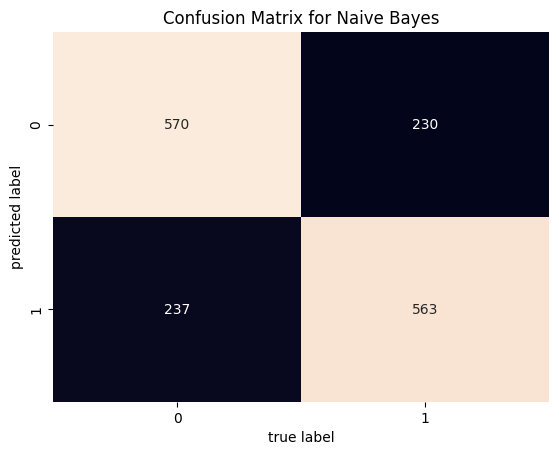

In [39]:
y_pred = clf.predict(x_test1)
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cbar=False)

plt.title('Confusion Matrix for Naive Bayes')
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()